# Modelo de Ising (Algoritmo Wolff)

In [1]:
import numpy as np
import math as m
import random as rand
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from collections import deque
import time

class IsingWolffSimulacion:
    def __init__(self, L, pasos_eq=1000, mc_pasos=1000, semilla=None):
        """
        __init__ Inicializa la retícula ajustada a ciertos parámetros como el tamaño, los pasos de equilibrio y los pasos Monte Carlo
    
        :self.L: Es el tamaño del lado de la retícula (cuadrada)
        :self.pasos_eq: Es el número de pasos para que la retícula alcance el equilibrio termodinamico
        :self.mc_pasos: Es el número de pasos Monte Carlo utilizados para tomar estadística de las variables termodinámicas del sistema
        :self.normal: Es un factor de normalización para tomar estadística
        :self.lattice: Inicializa la retícula de manera aleatoria con valores [1,-1]
        """
        self.L = L         
        self.N = L * L     
        self.pasos_eq = pasos_eq    
        self.mc_pasos = mc_pasos  
        self.normal = 1.0 /(self.N * self.mc_pasos)   
        self.lattice = np.random.choice([1, -1], size=(self.L, self.L)) 

    def seleccionar_sitio(self): 
        """
        seleccionar_sitio selecciona y retorna un sitio (coordenadas) de la lattice aleatoriamente
        :x: Coordenada x en la retícula seleccionada de manera aleatoria
        :y: Coordenada y en la retícula seleccionada de manera aleatoria
        """
        x = int(m.ceil(rand.random() * self.L)) - 1 
        y = int(m.ceil(rand.random() * self.L)) - 1
        return x, y
        
    def ajustar_coordenadas(self, x, y): 
        """
        ajustar_coordenadas es una función que toma un par de coordenadas (x, y) y las ajusta a condiciones de frontera periódicas (PBC) para un tamaño de retícula específico
        :x: Coordenada x en la retícula 
        :y: Coordenada y en la retícula 
        :return: Coordenadas con PBC
        """
        return (x % self.L ,y % self.L)
        
    def obtener_vecinos(self, x, y, T): 
        """
        obtener_vecinos elige los vecinos compatibles y los retorna con base en una decisión tipo Monte Carlo 
        :x: Coordenada x en la retícula 
        :y: Coordenada y en la retícula 
        :T: Temperatura de equilibrio del sistema
        :return: Lista de vecinos selecciones por el método MC
        """
        vecinos = [(x+1,y), (x,y+1), (x-1,y), (x,y-1)] #Vecinos cercanos (Ventana Neumann)
        vecinos_compatibles = [] #Lista de vecinos compatibles
        for vx, vy in vecinos: #Decisión Monte Carlo para decidir a qué vecinos añadir
            vx_ajustado, vy_ajustado = self.ajustar_coordenadas(vx, vy)
            if self.lattice[vx_ajustado][vy_ajustado] == self.lattice[x][y]:
                p_add = 1 - m.exp(-2/T)
                if rand.random() < p_add:
                    vecinos_compatibles.append((vx_ajustado, vy_ajustado))
        return vecinos_compatibles
        
    def cluster_wolff(self, x, y, T): 
        """
        cluster_wolff es una función que construye el cluster con base en las decisiones MC
        :x: Coordenada x en la retícula 
        :y: Coordenada y en la retícula 
        :T: Temperatura del sistema
        :return: El cluster que formamos con todos los vecinos seleccionados con el algoritmo Wolff
        """
        cluster = [] #Definimos un cluster vacío
        buffer = deque([(x, y)]) #Definimos un buffer de tipo FIFO (First In-First Out) para guardar y analizar las coordenadas de los vecinos compatibles
        visitado = [[False] * self.L for _ in range(self.L)]  # Matriz de vecinos previamente visitados
        visitado[x][y] = True  # Marcamos como visitada la coordenada inicial (x, y)
        
        while buffer: #Mientras el buffer no esté vacío
            x_b, y_b = buffer.popleft() #Obtenemos las primeras coordenadas del buffer
            cluster.append((x_b, y_b)) #Añadimos las coordenadas al cluster
            vecinos = self.obtener_vecinos(x_b, y_b, T) #Obtenemos los vecinos compatibles de este sitio
            for vx, vy in vecinos: #Ciclo para cada vecino
                if not visitado[vx][vy]: #Verificamos que no esté previamente visitado
                    buffer.append((vx, vy)) # Añadimos las coordenadas al buffer para repetir el proceso de compatibilidad 
                    visitado[vx][vy] = True #Marcamos el sitio como previamente visitado
        return cluster #Retornamos el cluster 

    def voltear_cluster(self, cluster): 
        """
        voltear_cluster es una función que para cada par de coordenadas en un cluster dado invierte el valor en la retícula
        :cluster: Una lista de vecinos compatibles y elegidos con el algoritmo de Wolff
        """
        for i, j in cluster:
            self.lattice[i][j] = -self.lattice[i][j]
            
    def graficar_lattice(self, T, dpi=50):
        """
        graficar_lattice toma el estado actual de la retícula y la grafica con colores blanco y negro para cada valor de espín
        :T: Temperatura actual del sistema
        :dpi: Resolución de la imagen (Dots per inch)
        """
        fig = plt.figure(figsize=(5, 5), dpi=dpi)
        cmap = ListedColormap(['white', 'black'])
        plt.imshow(self.lattice, cmap=cmap, interpolation='none', vmin=-1, vmax=1)
        plt.title(f'T={T:.2f}')
        plt.xticks([])
        plt.yticks([])
        plt.close(fig)  # Evita que se muestren las figuras individualmente
        return fig

    def energia_sitio(self, x, y):
        """
        energia_sitio calcula la energía de un sitio con respecto a una ventana de Neumann
        :x: Coordenada x del sitio elegido en la retícula 
        :y: Coordenada y del sitio elegido en la retícula 
        :return: Retorna la función energía por sitio correspondiente al modelo de Ising 2-dimensional
        """
        vecinos = [
            ((x + 1) % self.L, y),  # Derecha
            ((x - 1) % self.L, y),  # Izquierda
            (x, (y + 1) % self.L),  # Arriba
            (x, (y - 1) % self.L)   # Abajo
        ]
        suma_vecinos = 0
        for vx, vy in vecinos:
            suma_vecinos += self.lattice[vx][vy]
        return -self.lattice[x][y] * suma_vecinos
        
    def energia_total(self):
        """
        energia_total calcula la energia total de la retícula
        :return: Energia total de la retícula
        """
        energia = 0
        for i in range(0, self.L):
            for j in range(0, self.L):
                energia += self.energia_sitio(i, j)
        return energia

    def energia_cluster(self, cluster):
        """
        energia_cluster calcula la energia total de un cluster construido
        :return: Energia total del cluster
        """
        e = 0
        for N in range(0, len(cluster)):
            x = cluster[N][0]
            y = cluster[N][1]
            e += self.energia_sitio(x,y)
        return e

    def magnetizacion_total(self):
        """
        magnetizacion_total calcula la magnetización total de la retícula sumando todos los espines en la retícula
        :return: Magnetización total de la retícula
        """
        mag = 0
        for i in range(0, self.L):
            for j in range(0, self.L):
                mag += self.lattice[i][j]
        return mag

    def ejecutar_simulacion(self, T):
        """
        ejecutar_simulacion es una función que realiza el algoritmo de Wolff para un sistema a una temperatura fija con cierto número de pasos de equilibrio
        :T: Temperatura del sistema
        """
        for i in range(self.pasos_eq):
            x, y = self.seleccionar_sitio()
            cluster = self.cluster_wolff(x, y, T)
            self.voltear_cluster(cluster)        

    def experimentos_mc(self):
        """
        experimentos_mc realiza toda la estadística con un cierto número de pasos MC
        :temp: Es una lista de valores de temperatura desde 1.5 a 5 con distancia del paso de 0.1
        :magnet: Array para estadística en todo el rango de temperaturas
        :return: Retornamos todas las listas creadas (parámetros de orden) para graficar la estadística así como el rango de temperaturas
        """
        temp = [t for t in np.arange(0.5, 5.1, 0.1)]#Lista de valores de temperatura desde 1.5 a 5 con pasos de 0.1
        magnet = np.array([]) #Inicializamos arrays para estadística
        magnet_abs = np.array([])
        mabstot_avg = np.array([])
        etot_avg = np.array([])
        etotsq_avg = np.array([])
        sustot_avg = np.array([])
        binder = np.array([])
        for T in temp:
            self.ejecutar_simulacion(T) #Primero hacemos que la lattice alcance el equilibrio termodinámico
            E = self.energia_total() # Inicializamos variables globales
            M = self.magnetizacion_total()
            M_abs = np.absolute(self.magnetizacion_total())
            e_tot = 0 #Inicializamos variables para estadística 
            e_totsq = 0 #Energía total al cuadrado
            m_tot = 0 #Magnetizacion total
            m_totsq = 0 #Magnetizacion total al cuadrado
            m_qtot = 0 #Magnetización total a la cuarta
            m_abstot = 0 #Magnetizacion absoluta total
            for i in range(0, self.mc_pasos):     #Loop Monte Carlo 
                x, y = self.seleccionar_sitio() #Elegimos sitio aleatorio en la lattice
                cluster = self.cluster_wolff(x, y, T)
                e_i = self.energia_cluster(cluster) 
                self.voltear_cluster(cluster)
                e_f = self.energia_cluster(cluster)
                delta = e_f - e_i
                E += 2*delta #Si se cambia el espín entonces modificamos las variables globales
                M += 2*len(cluster)*self.lattice[x][y]
                e_tot += float(E/2) #Para cada paso Monte Carlo sumamos a las variables totales el valor global
                e_totsq += float(E/2 * E/2)
                m_tot += float(M)
                m_totsq += float(M * M)
                m_qtot += float(M * M * M * M)
                m_abstot += float(np.sqrt(M * M)) 
                #magnet = np.append(magnet, M) 
                #magnet_abs = np.append(magnet_abs, np.sqrt(M*M))
        
            e_avg = e_tot*self.normal
            esq_avg = e_totsq*self.normal/self.N
            m_avg = m_tot*self.normal
            mabs_avg = m_abstot*self.normal
            msq_avg = m_totsq*self.normal
            mq_avg = m_qtot*self.normal
            binder_p = 1 - (mq_avg*self.N/(3*(msq_avg*msq_avg*self.N**2)))
            sus_avg = (msq_avg - (mabs_avg*mabs_avg*self.N))/T
            etot_avg = np.append(etot_avg, e_avg)
            etotsq_avg = np.append(etotsq_avg, esq_avg)
            mabstot_avg = np.append(mabstot_avg, mabs_avg)
            sustot_avg = np.append(sustot_avg, sus_avg)
            binder = np.append(binder, binder_p)

        return temp, etot_avg, etotsq_avg, mabstot_avg, sustot_avg, binder

## Transición de fase (Representación gráfica)

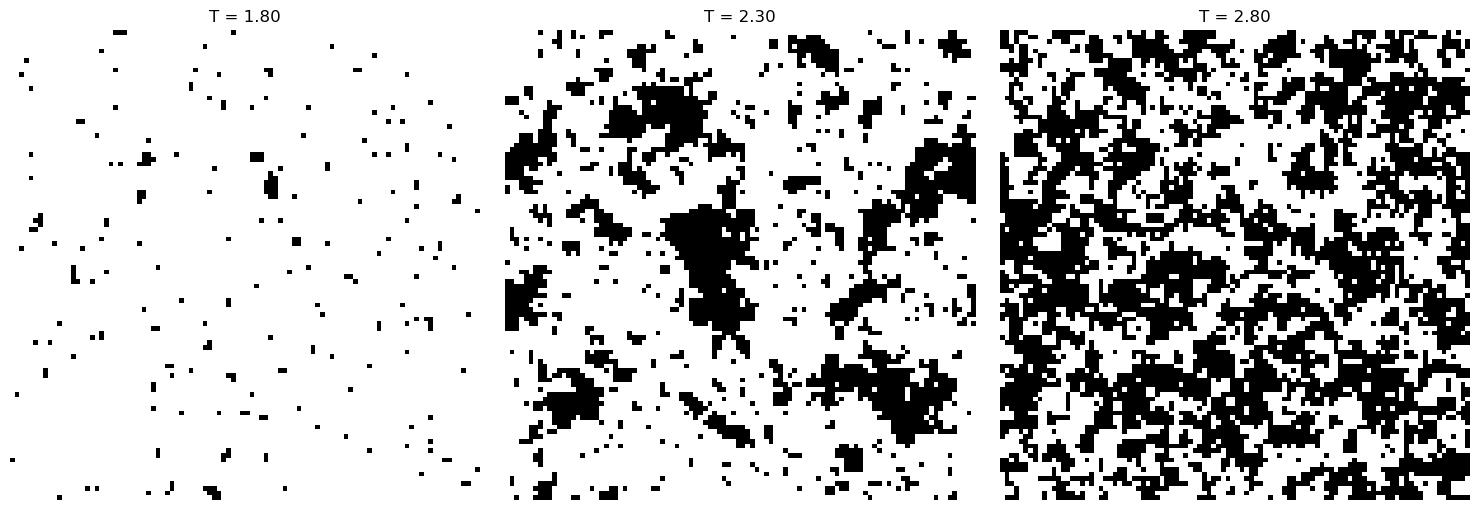

El tiempo de ejecución es de t=52.18868899345398 segundos


In [4]:
#Prueba de transición de fase visual.
inicio = time.time()
temp = [1.8, 2.3, 2.8]
figuras= []
simul = IsingWolffSimulacion(L=100, pasos_eq=1000)
for T in temp:
    #simul.graficar_lattice(T)
    simul.ejecutar_simulacion(T)
    fig = simul.graficar_lattice(T)
    figuras.append(fig)

fig_combinada, axs = plt.subplots(1, len(figuras), figsize=(15, 5))
for ax, (fig, T) in zip(axs, zip(figuras, temp)):
    # Extraer la imagen de cada figura individual
    for child in fig.get_children():
        if isinstance(child, plt.Axes):
            im = child.get_images()[0]
            break
    ax.imshow(im.get_array(), cmap=im.get_cmap(), vmin=-1, vmax=1)
    ax.set_title(f'T = {T:.2f}')
    ax.axis('off')

plt.tight_layout()
plt.show()
fin = time.time()
print(f"El tiempo de ejecución es de t={fin-inicio} segundos")

## Estadística del modelo (Wolff)

Realizando la simulación de la lattice de tamaño 4...
Simulación de tamaño 4 terminada
Realizando la simulación de la lattice de tamaño 8...
Simulación de tamaño 8 terminada
Realizando la simulación de la lattice de tamaño 16...
Simulación de tamaño 16 terminada
Realizando la simulación de la lattice de tamaño 32...
Simulación de tamaño 32 terminada
Realizando la simulación de la lattice de tamaño 64...
Simulación de tamaño 64 terminada
Realizando la simulación de la lattice de tamaño 128...
Simulación de tamaño 128 terminada


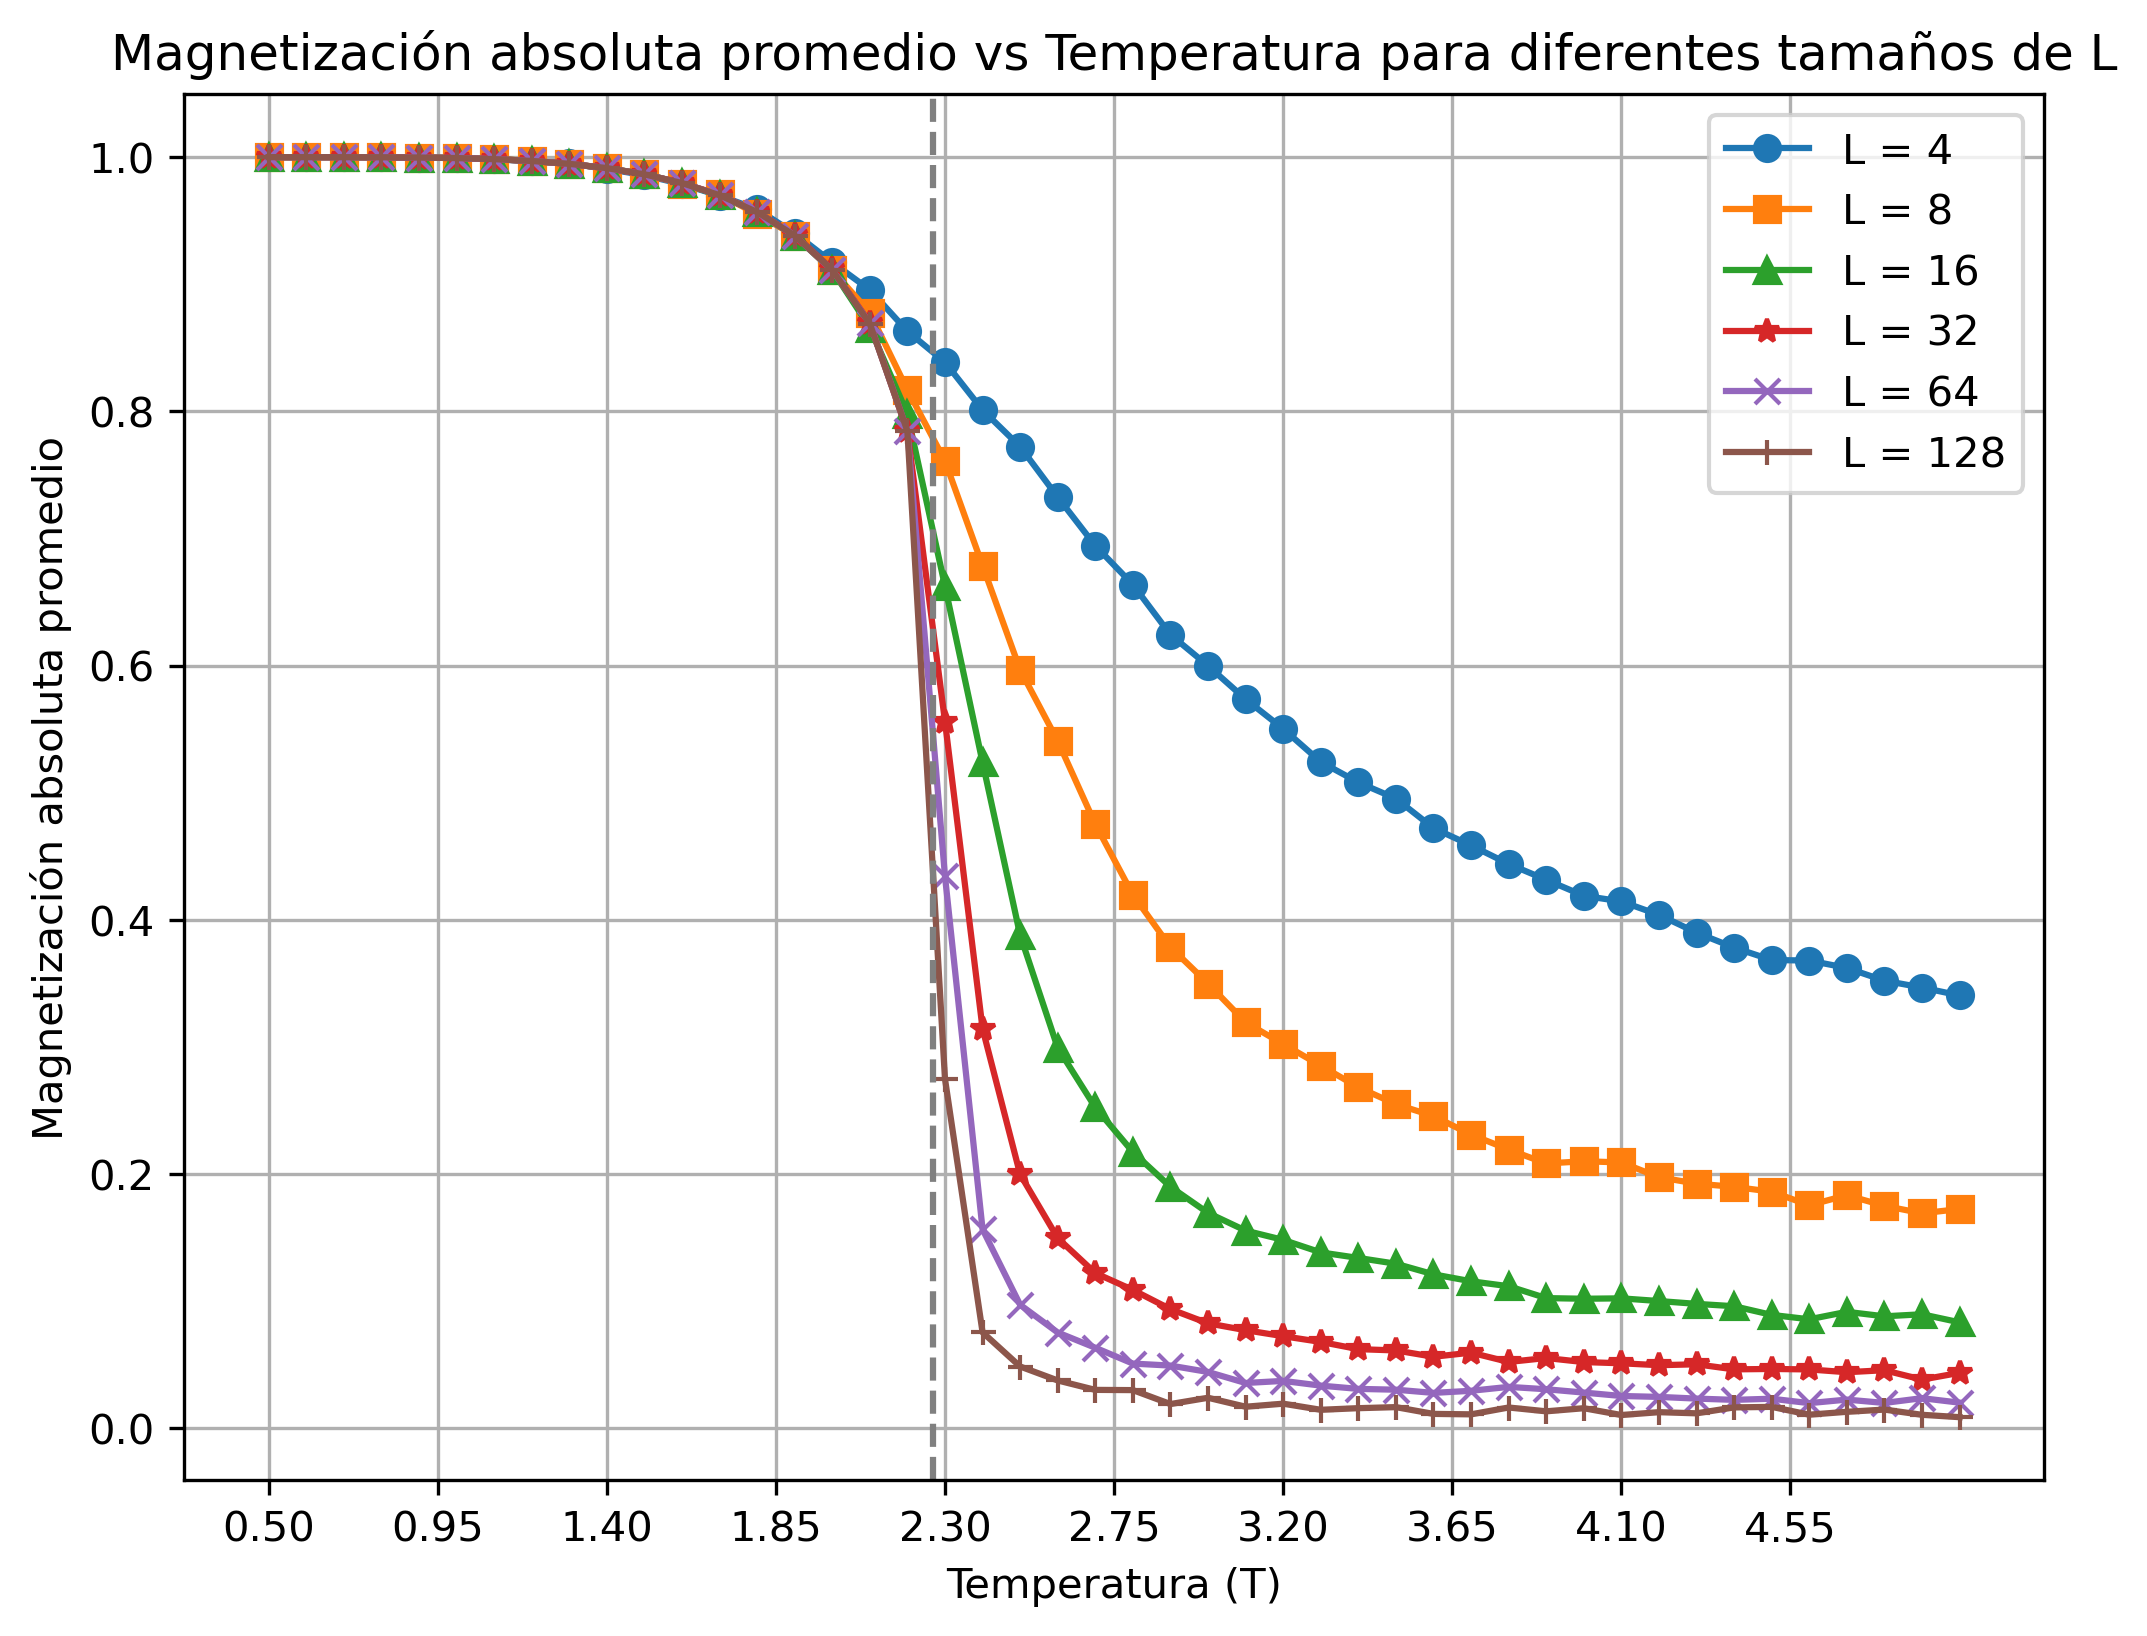

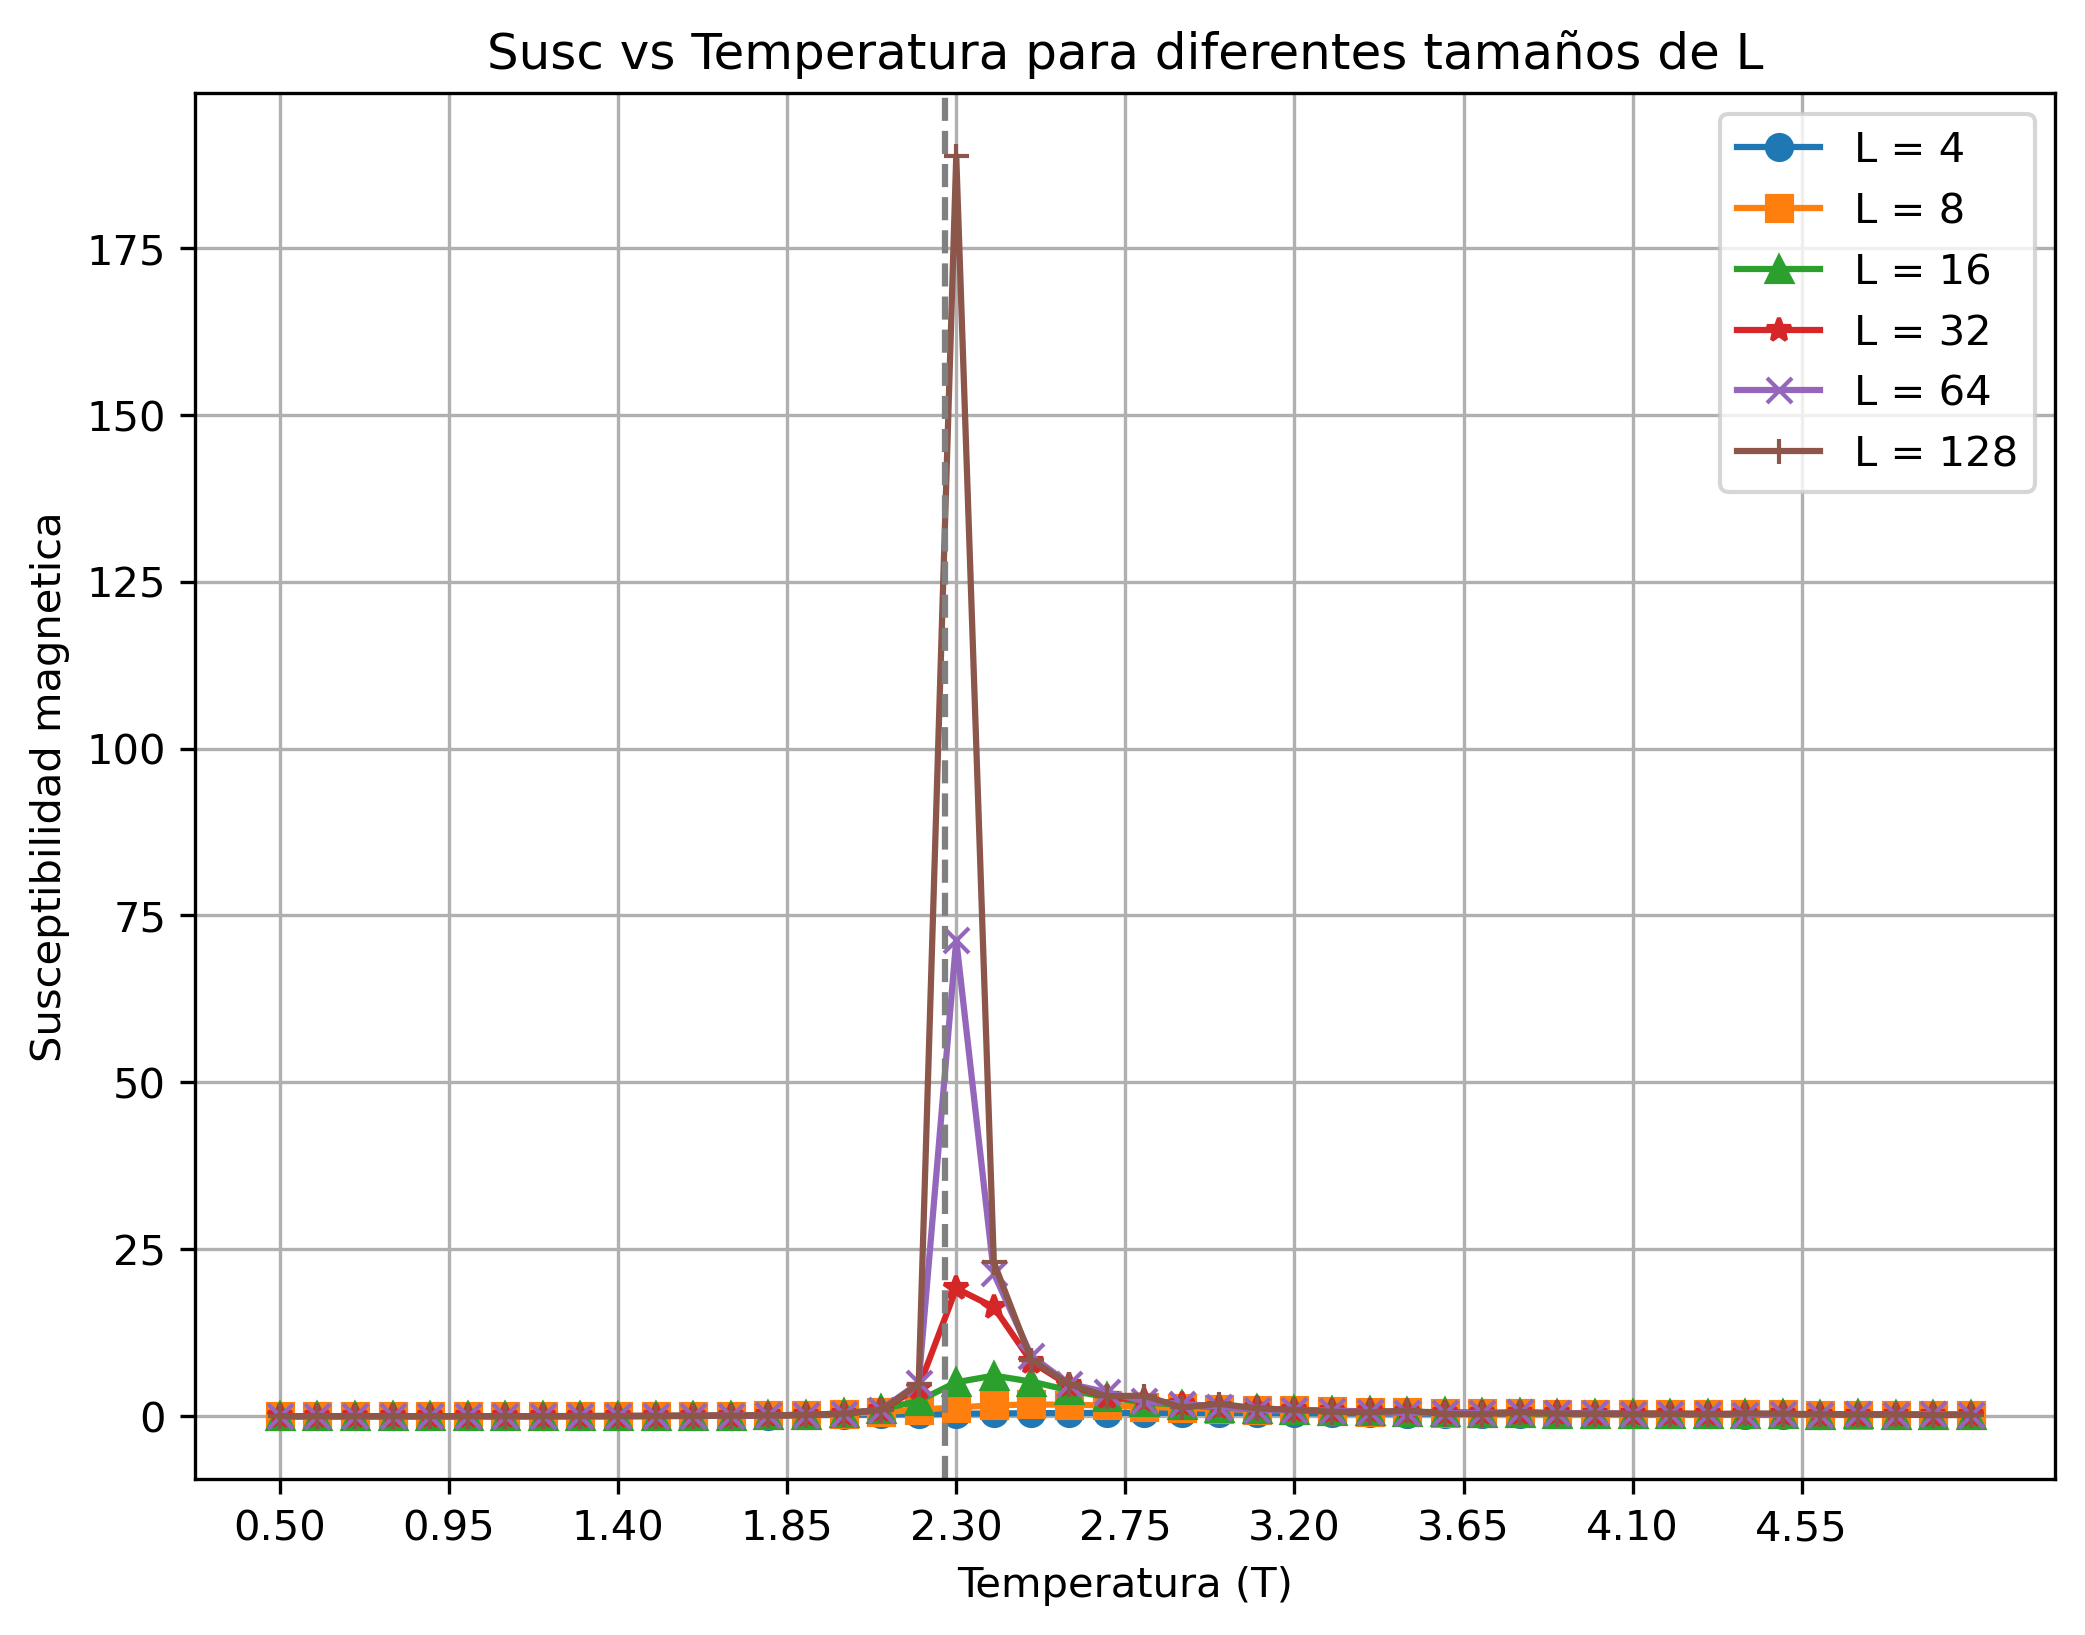

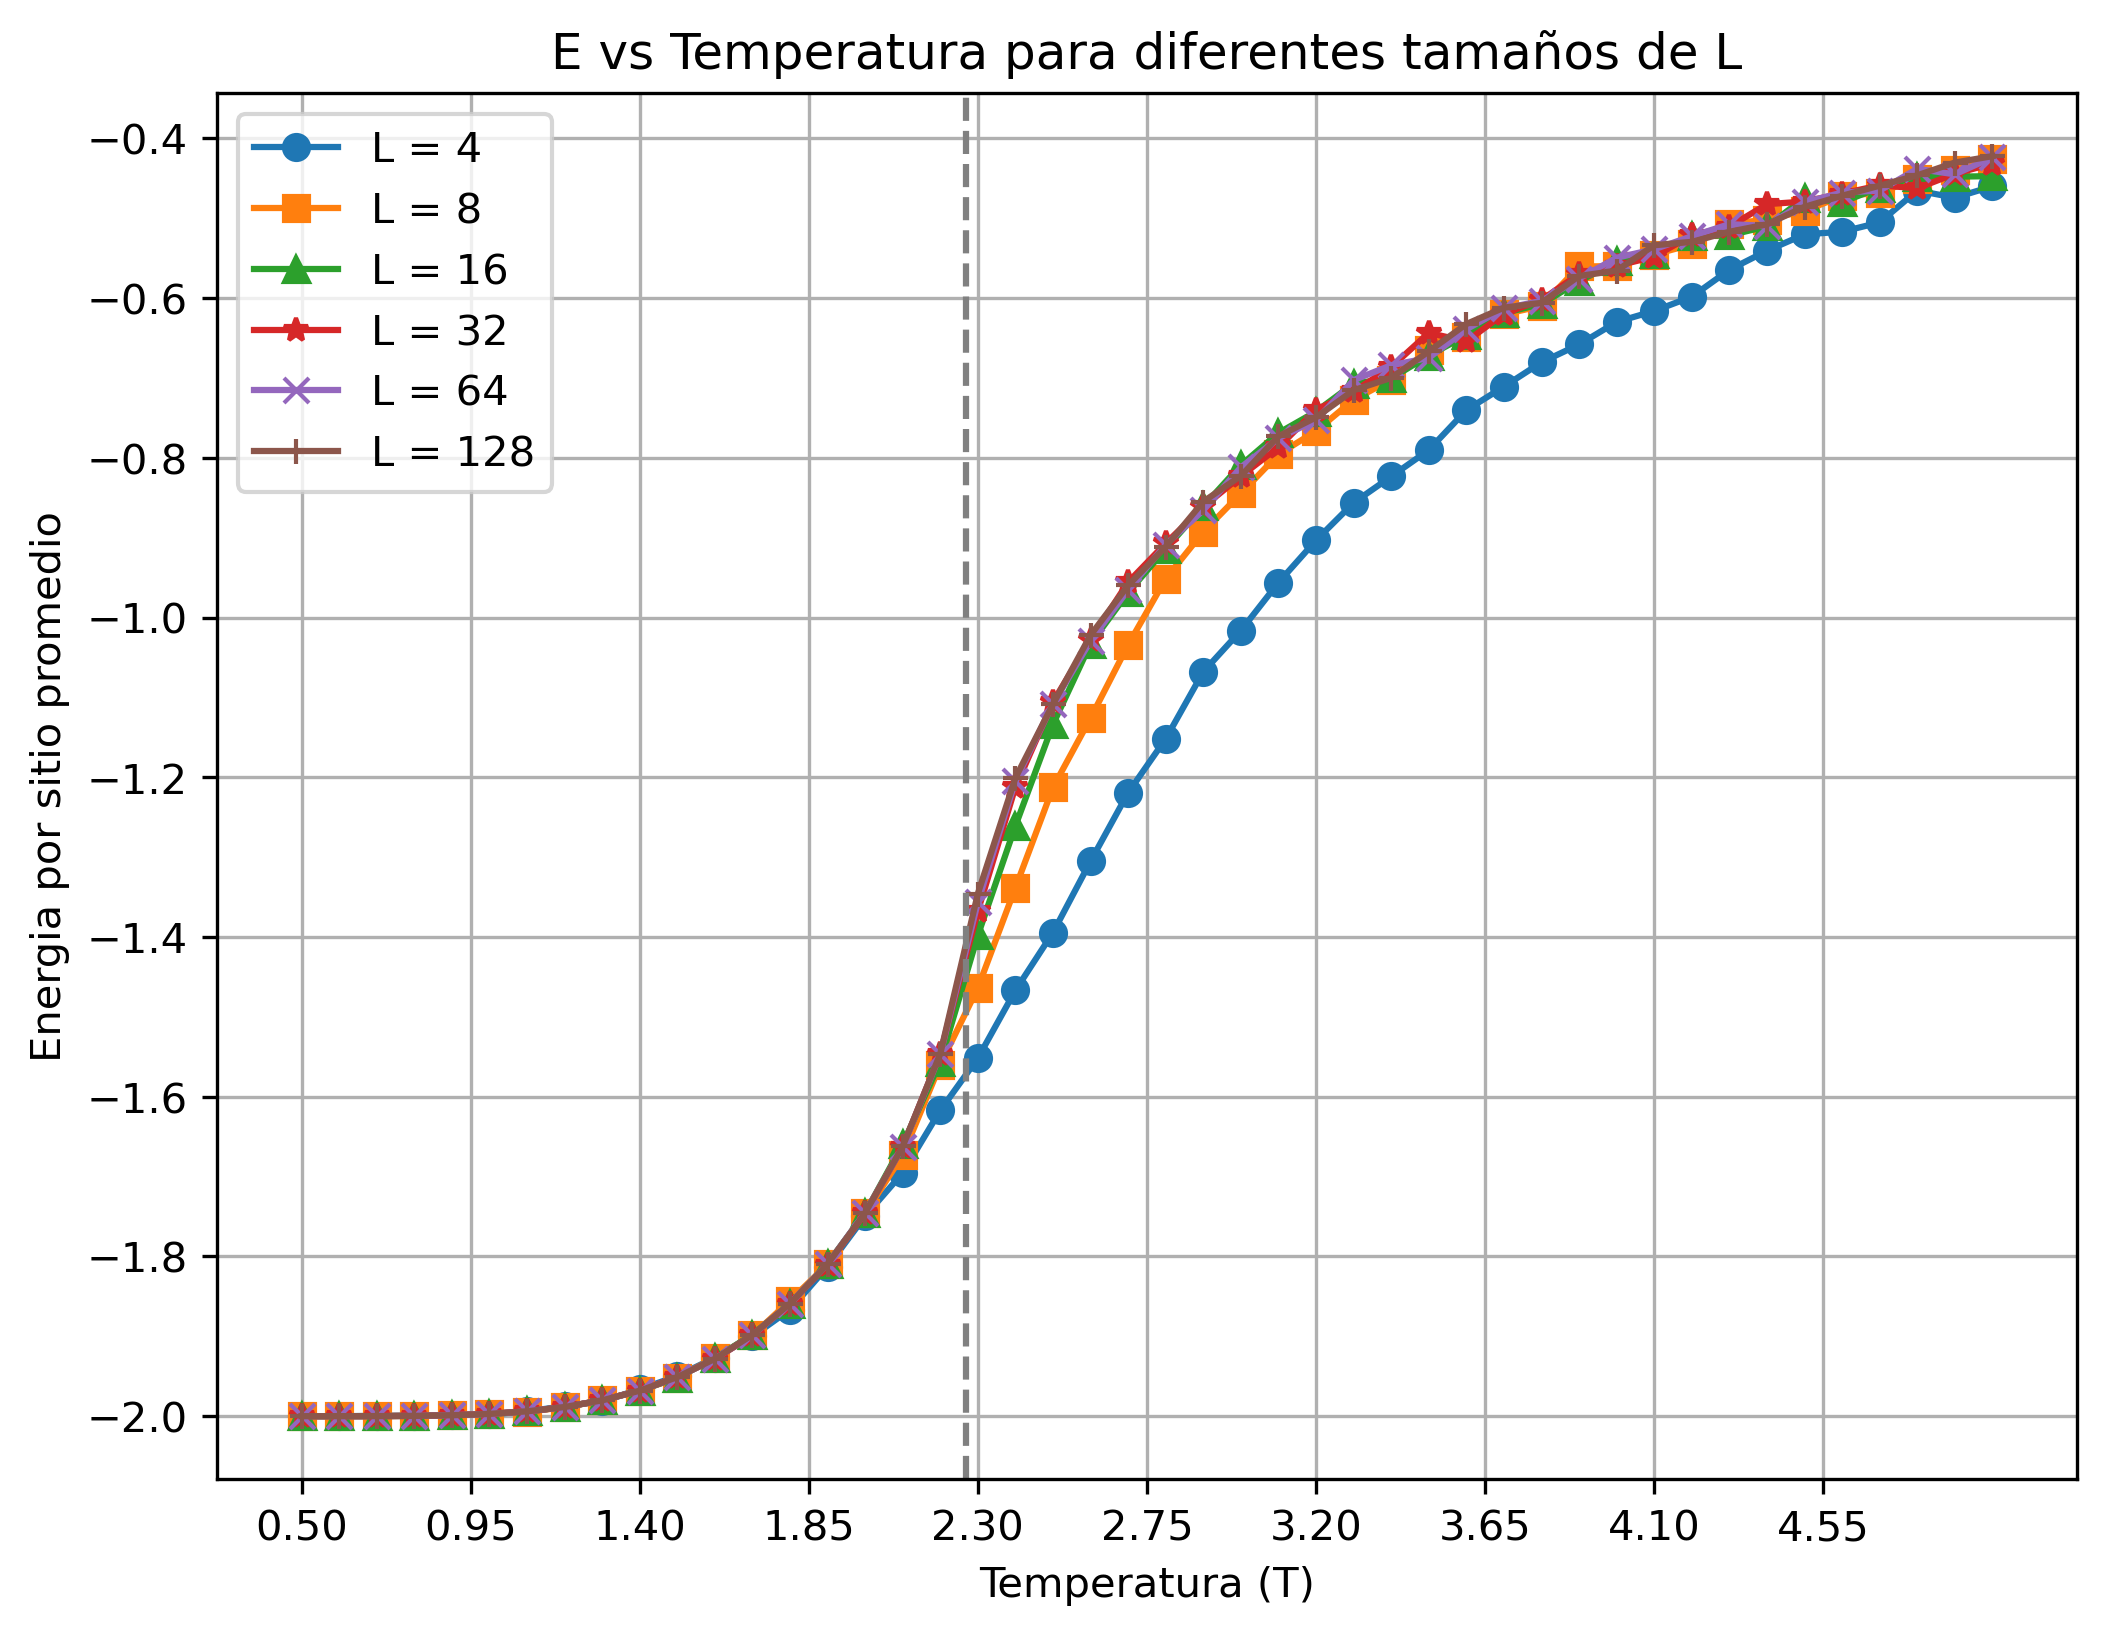

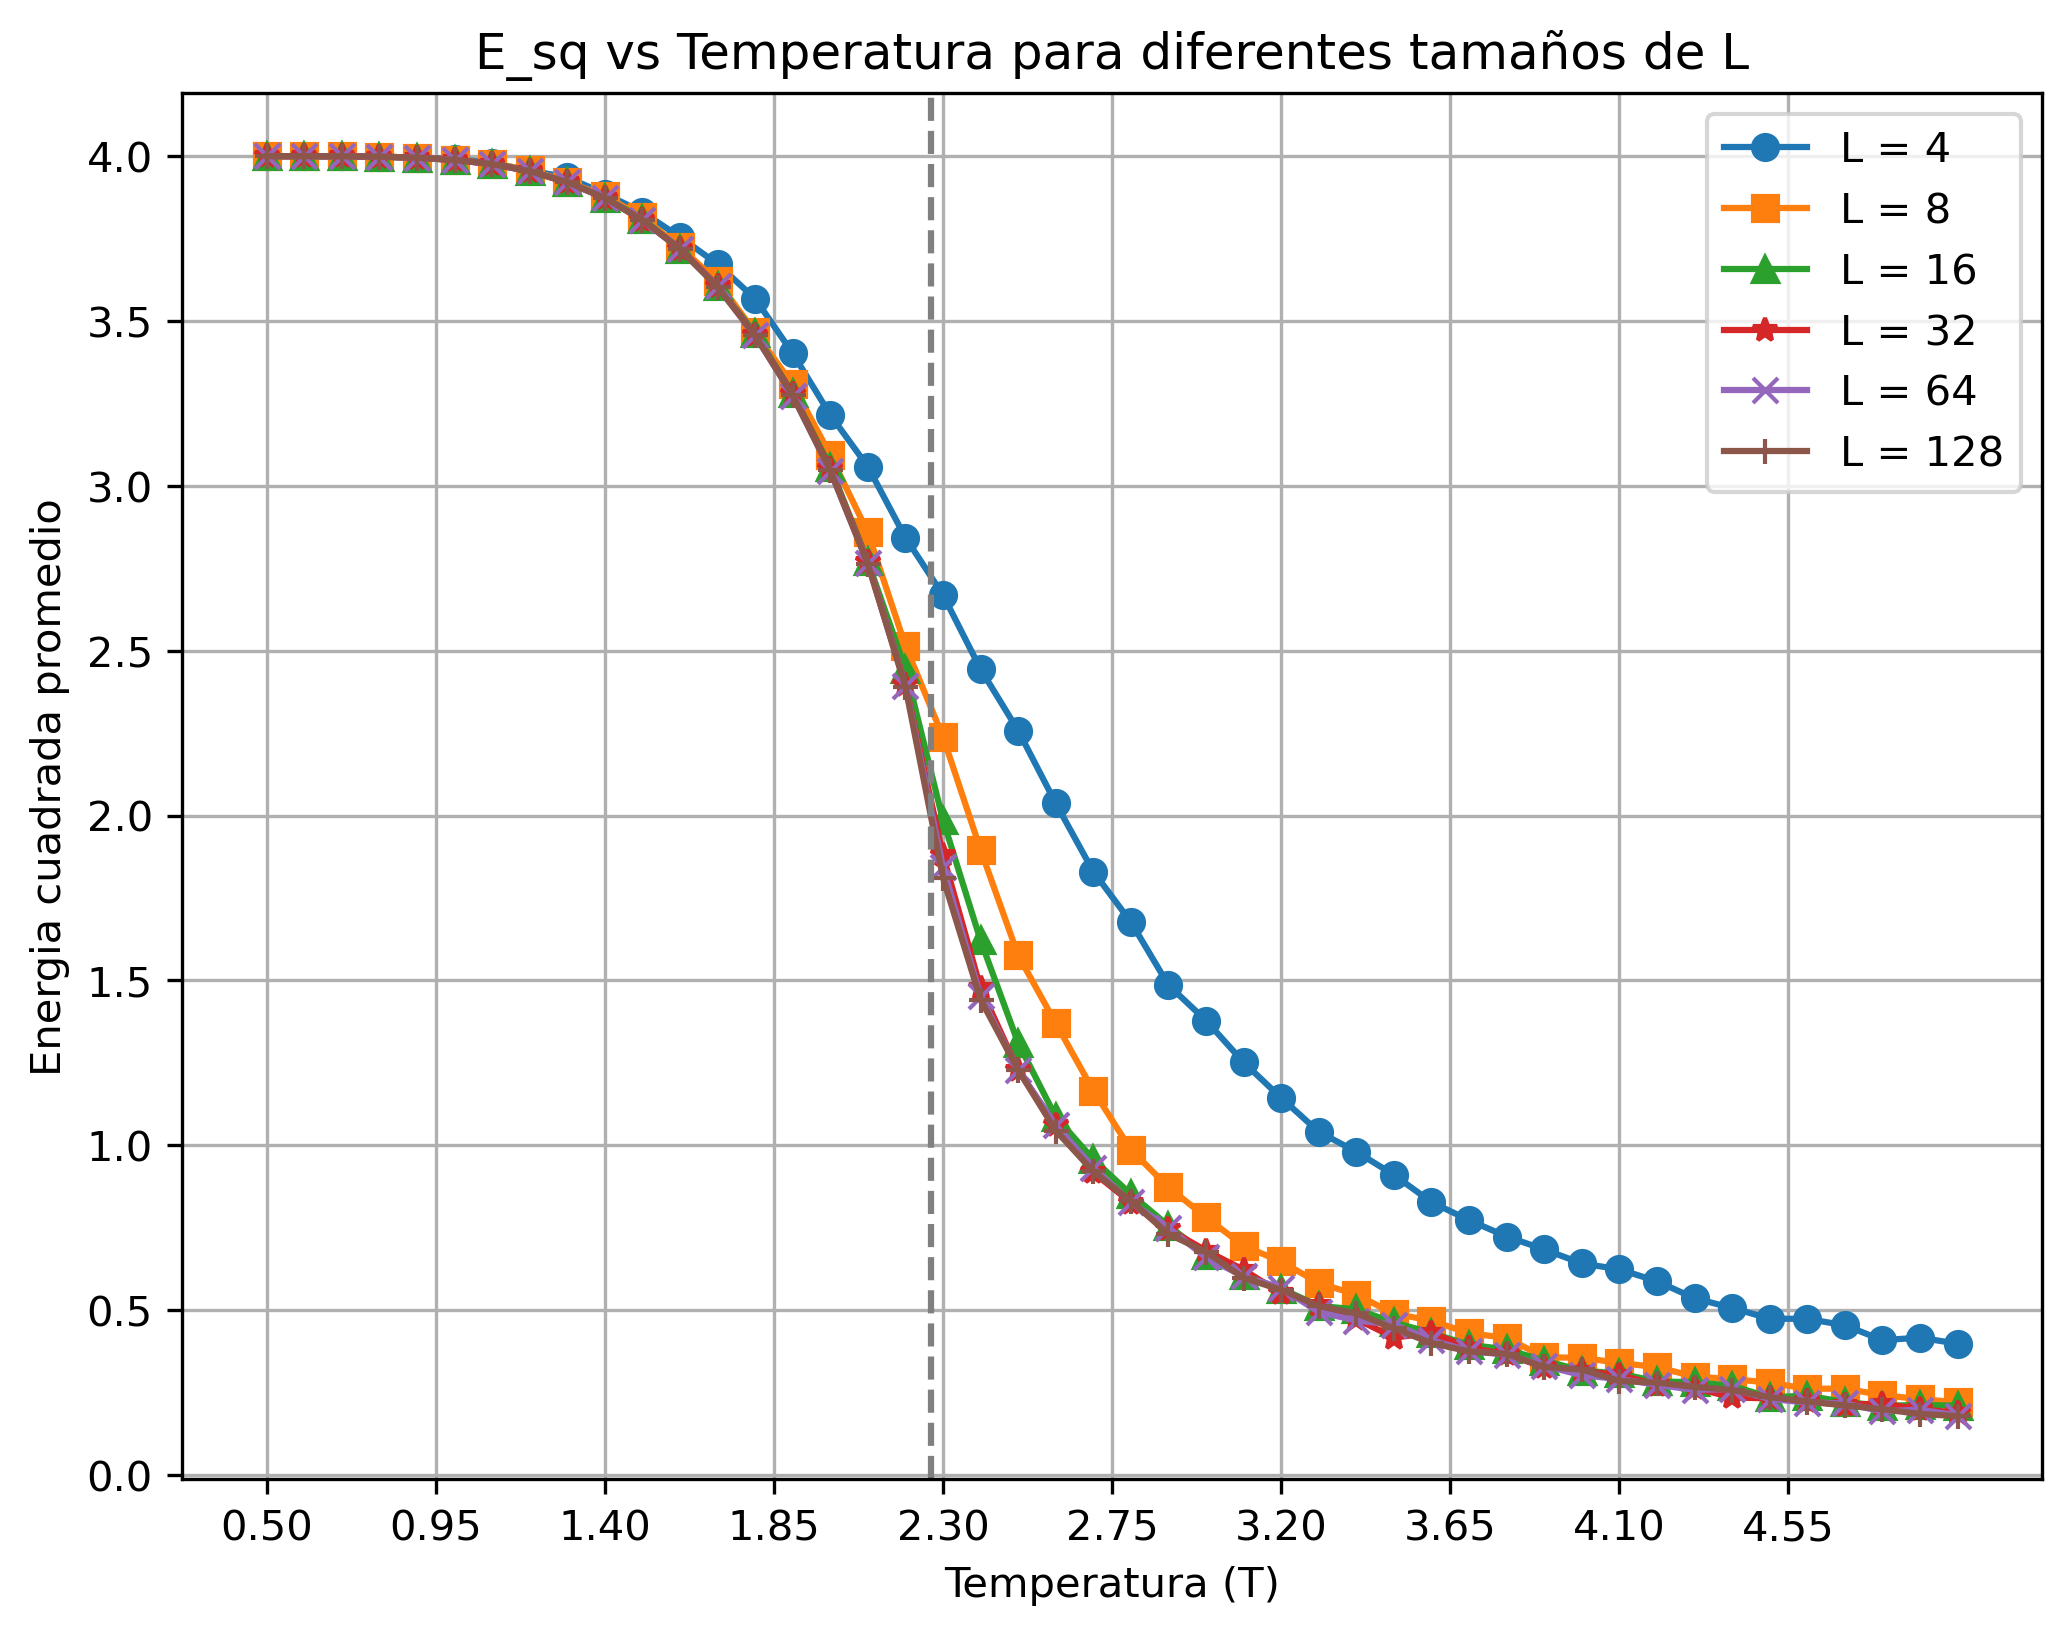

65873.56605696678


In [86]:
ini = time.time()
tamaño = [4, 8, 16, 32, 64, 128] #Definimos una lista con tamaños de L
marcadores = ['o', 's', '^', '*', 'x', '+'] #Definimos los distintos marcadores de la gráfica 


fig1, ax1 = plt.subplots(figsize=(8, 6), dpi=300)  # Figura para Magnetización
fig2, ax2 = plt.subplots(figsize=(8, 6), dpi=300)  # Figura para Susceptibilidad
fig3, ax3 = plt.subplots(figsize=(8, 6), dpi=300)  # Figura para Energia
fig4, ax4 = plt.subplots(figsize=(8, 6), dpi=300) #Figura para energia cuadrada
#fig5, ax5 = plt.subplots(figsize=(8,6), dpi=300) #Figura del parametro de Binder
binder_l = []
for lado, marcador in zip(tamaño, marcadores):
    print(f"Realizando la simulación de la lattice de tamaño {lado}...")
    simul = IsingWolffSimulacion(L=lado, pasos_eq=1000, mc_pasos=10000)
    temp, etot_avg, etotsq_avg, mabstot_avg, sustot_avg, binder = simul.experimentos_mc()
    binder_l.append(binder)
    ax1.plot(temp, mabstot_avg, label=f"L = {simul.L}", linestyle='-', marker=marcador)
    ax2.plot(temp, sustot_avg, label=f"L = {simul.L}", linestyle='-', marker=marcador)
    ax3.plot(temp, etot_avg, label=f"L = {simul.L}", linestyle='-', marker=marcador)
    ax4.plot(temp, etotsq_avg, label=f"L = {simul.L}", linestyle='-', marker=marcador)
    print(f"Simulación de tamaño {lado} terminada")
"""
ratios = ["2/4", "4/8", "8/16", "16/32", "32/64"]
r1 = [x/y for x, y in zip(binder_l[0], binder_l[1])]
r2 = [x/y for x, y in zip(binder_l[1], binder_l[2])]
r3 = [x/y for x, y in zip(binder_l[2], binder_l[3])]
r4 = [x/y for x, y in zip(binder_l[3], binder_l[4])]
r5 = [x/y for x, y in zip(binder_l[4], binder_l[5])]
bins = [r1,r2]#[14:19], r2[14:19]]
temp2 = temp#[14:19]
for ratio, binders in zip(ratios, bins):
    ax5.plot(temp2, binders, label=f"r = {ratio}", linestyle='-', marker=marcador)
"""    

ax1.set_xlabel("Temperatura (T)")
ax1.set_ylabel("Magnetización absoluta promedio")
ax1.set_title("Magnetización absoluta promedio vs Temperatura para diferentes tamaños de L")
ax1.legend()
ax1.grid()
ax1.set_xticks(np.arange(min(temp), max(temp), step=(max(temp) - min(temp))/10))  # 10 divisiones en el eje X

ax2.set_xlabel("Temperatura (T)")
ax2.set_ylabel("Susceptibilidad magnetica")
ax2.set_title("Susc vs Temperatura para diferentes tamaños de L")
ax2.legend()
ax2.grid()
ax2.set_xticks(np.arange(min(temp), max(temp), step=(max(temp) - min(temp))/10))  # 10 divisiones en el eje X

ax3.set_xlabel("Temperatura (T)")
ax3.set_ylabel("Energia por sitio promedio")
ax3.set_title("E vs Temperatura para diferentes tamaños de L")
ax3.legend()
ax3.grid()
ax3.set_xticks(np.arange(min(temp), max(temp), step=(max(temp) - min(temp))/10))  # 10 divisiones en el eje X

ax4.set_xlabel("Temperatura (T)")
ax4.set_ylabel("Energia cuadrada promedio")
ax4.set_title("E_sq vs Temperatura para diferentes tamaños de L")
ax4.legend()
ax4.grid()
ax4.set_xticks(np.arange(min(temp), max(temp), step=(max(temp) - min(temp))/10))  # 10 divisiones en el eje X

ax1.axvline(x = 2.269, color = 'grey', linestyle='--', label = 'T_c = 2.269...')
ax2.axvline(x = 2.269, color = 'grey', linestyle='--', label = 'T_c = 2.269...')
ax3.axvline(x = 2.269, color = 'grey', linestyle='--', label = 'T_c = 2.269...')
ax4.axvline(x = 2.269, color = 'grey', linestyle='--', label = 'T_c = 2.269...')

"""
ax5.set_xlabel("Temperatura (T)")
ax5.set_ylabel("U_L/U_L'")
ax5.set_title("Ratios de cumulantes vs Temperatura")
ax5.legend()
ax5.grid()
ax5.set_xticks(np.arange(min(temp2), max(temp2), step=(max(temp2) - min(temp2))/10))  # 10 divisiones en el eje X
ax5.set_yticks(np.arange(min(binders), max(binders), step=(max(binders) - min(binders))/10))
"""
plt.show()
fin = time.time()
print(fin-ini)

## Gráficas del parámetro de Binder (Transición de fase)

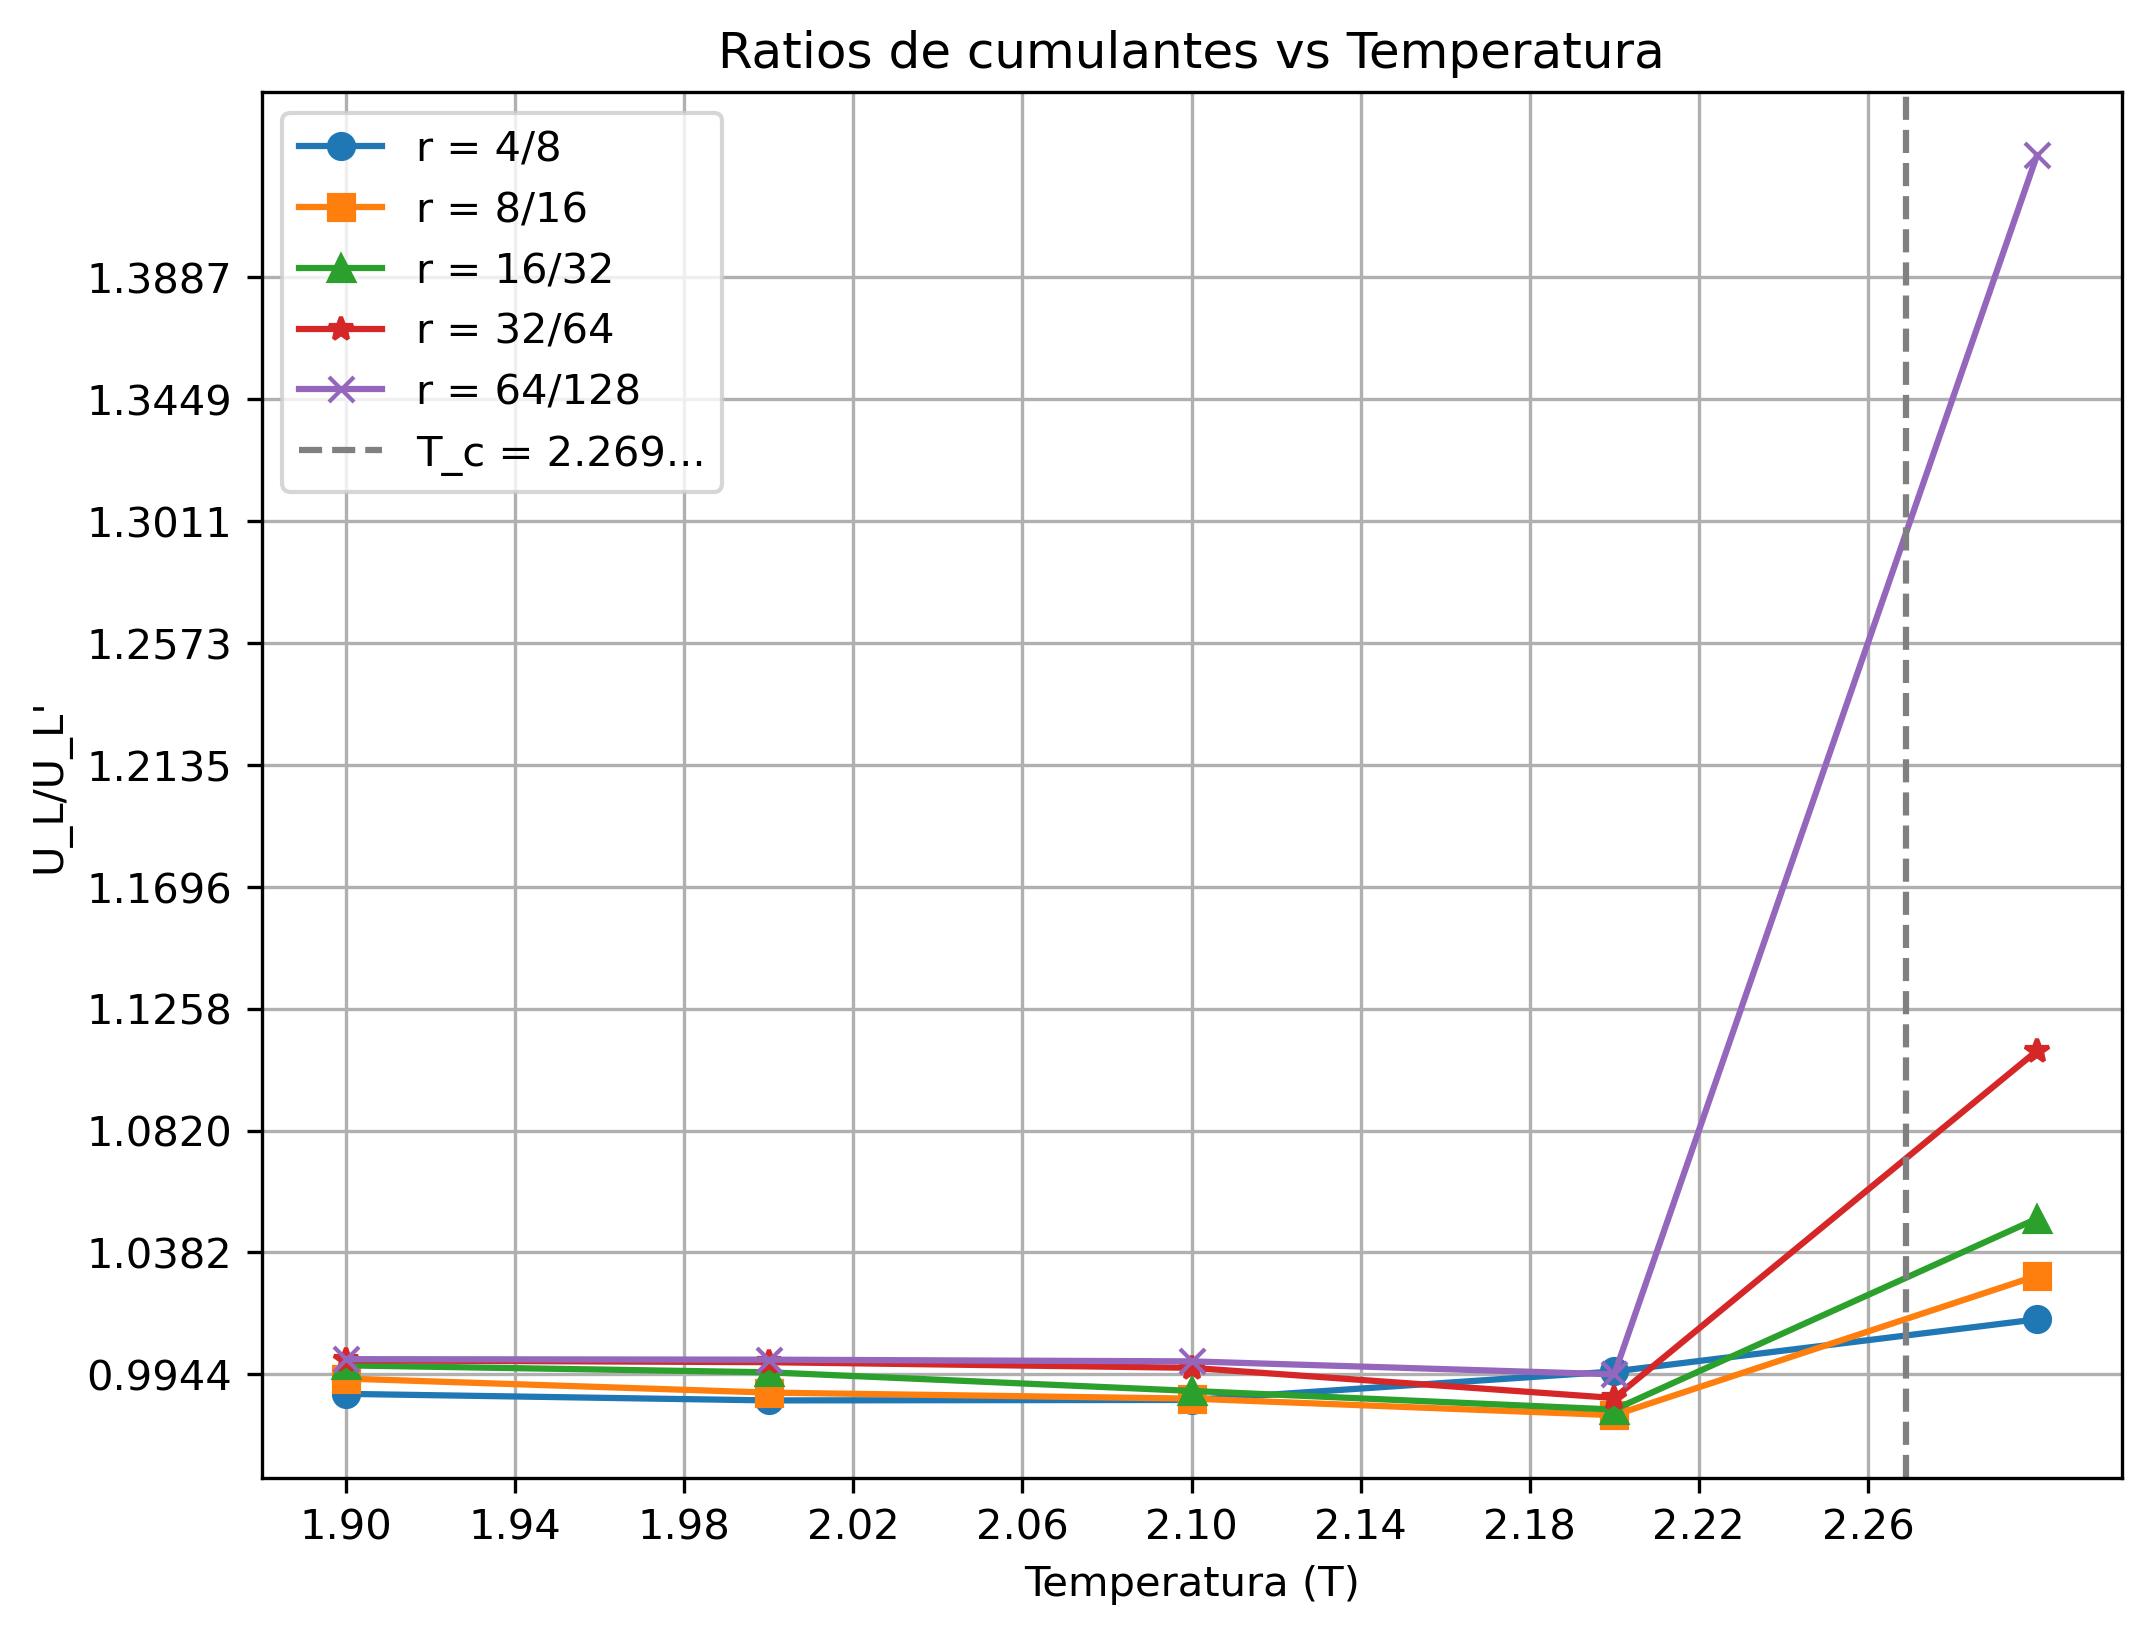

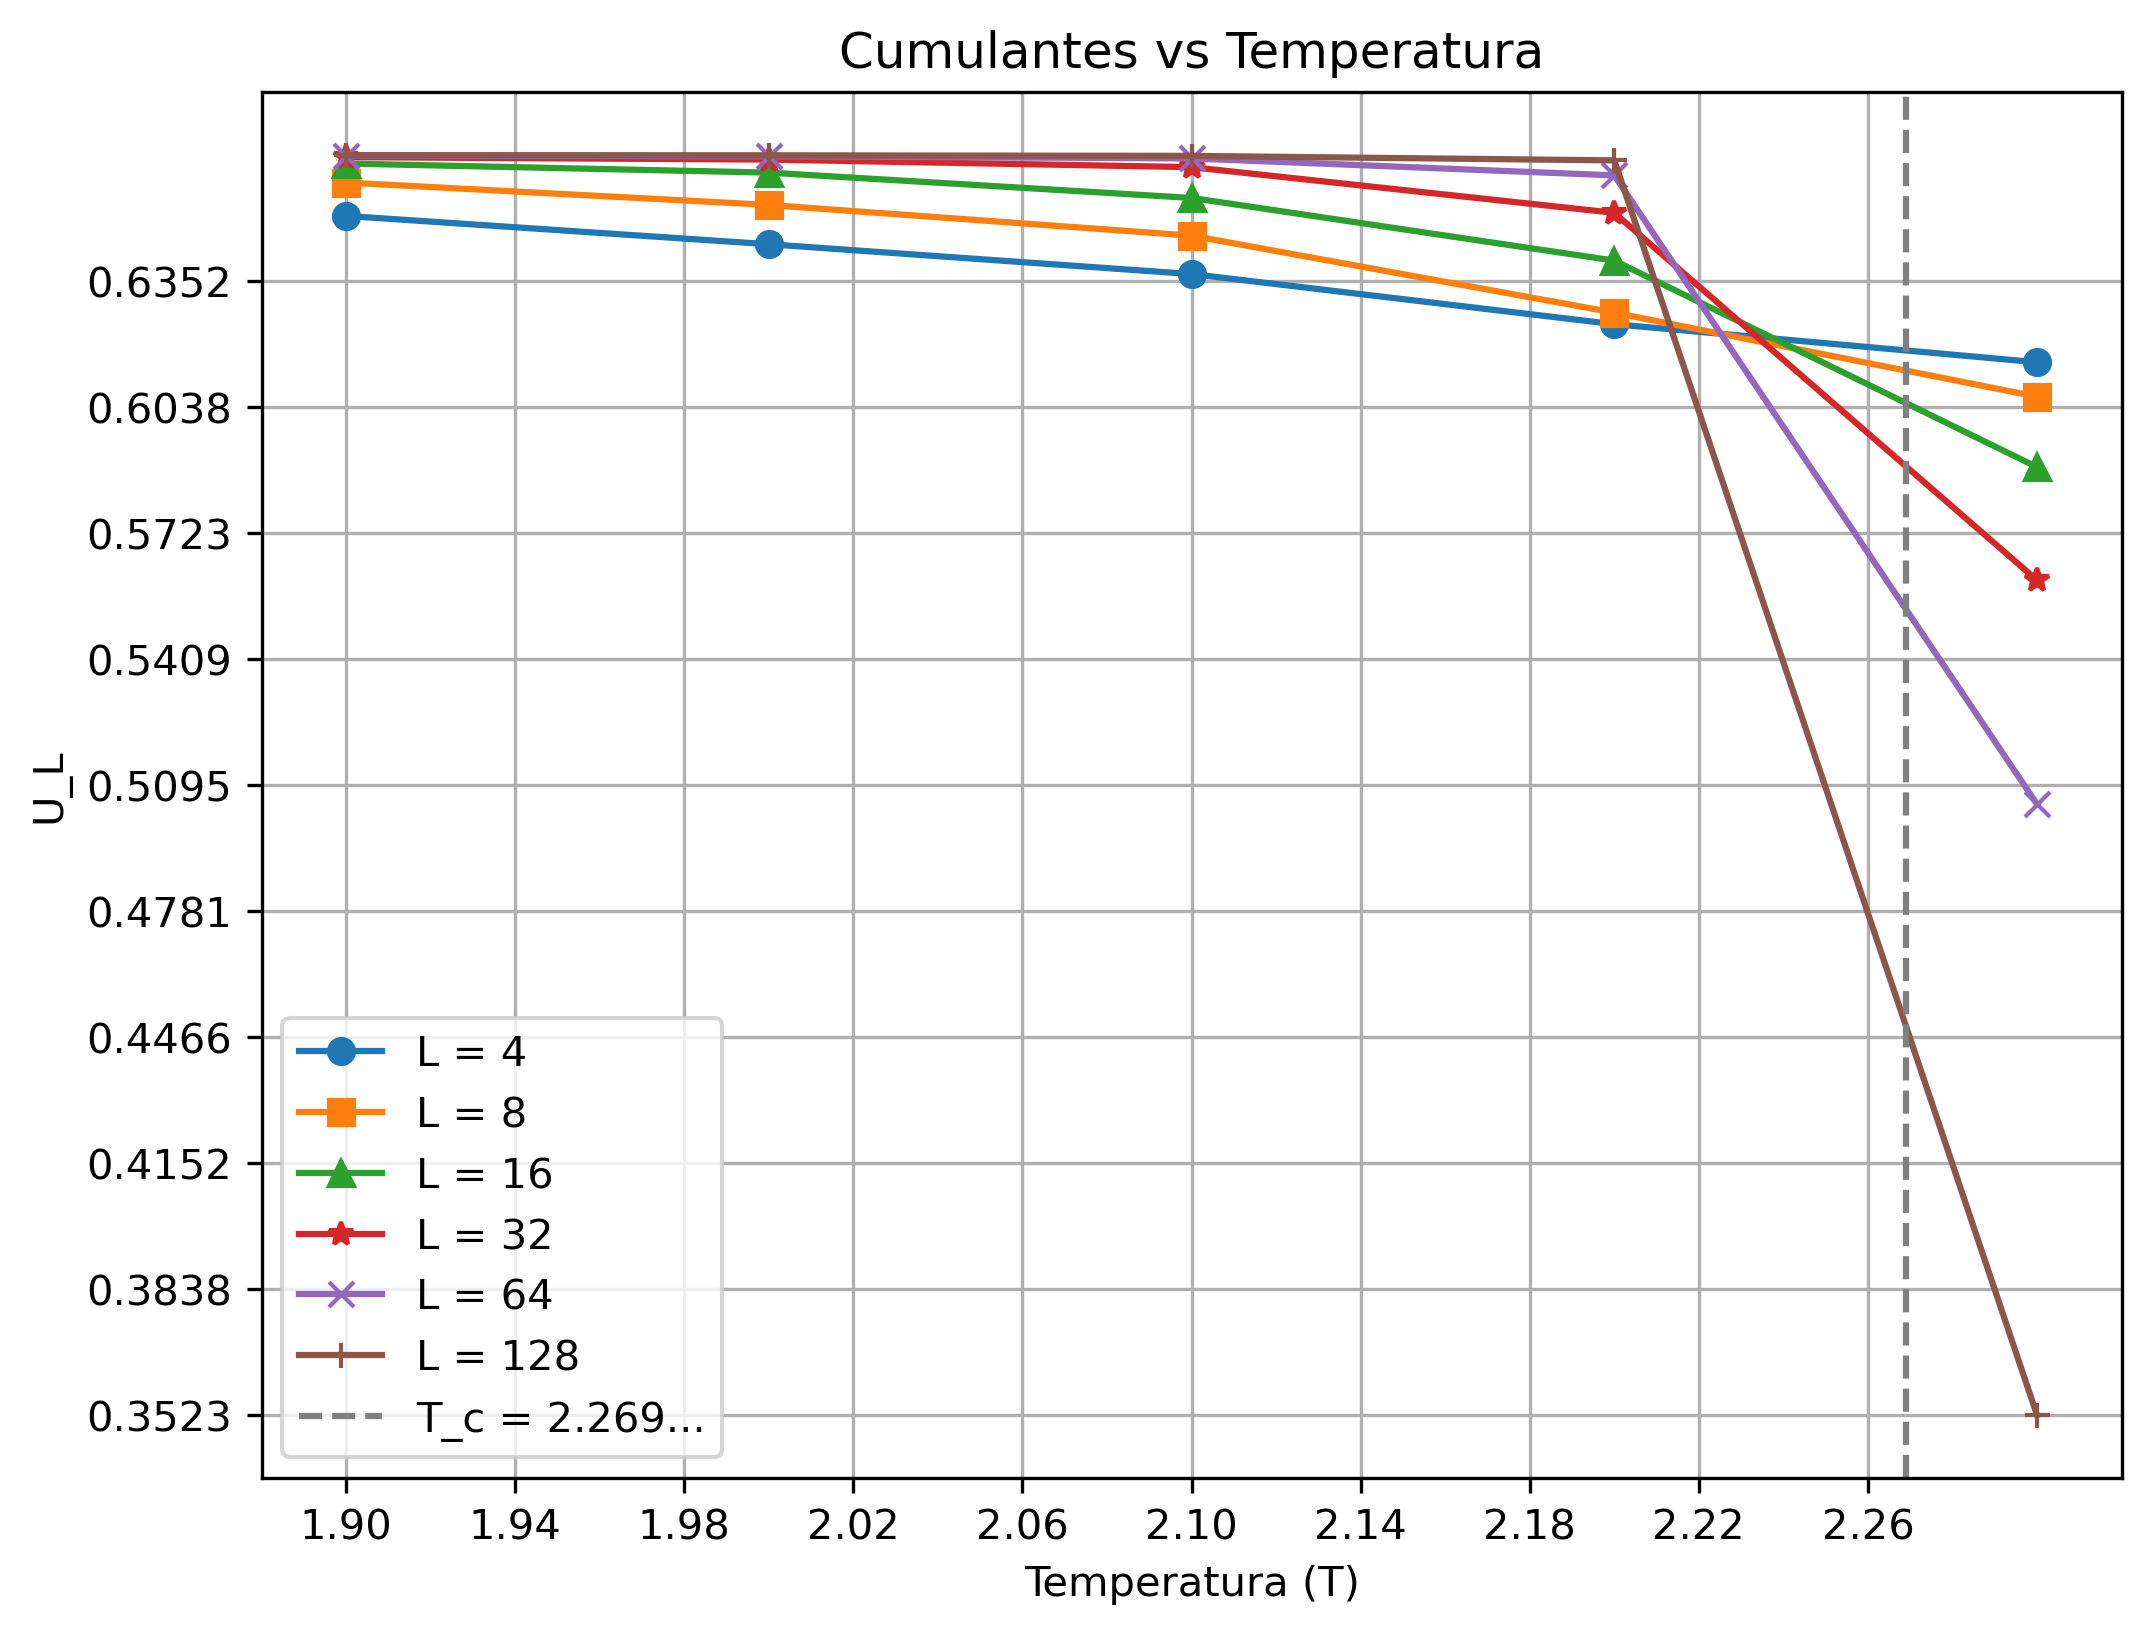

In [89]:
r1 = [x/y for x, y in zip(binder_l[0], binder_l[1])]
r2 = [x/y for x, y in zip(binder_l[1], binder_l[2])]
r3 = [x/y for x, y in zip(binder_l[2], binder_l[3])]
r4 = [x/y for x, y in zip(binder_l[3], binder_l[4])]
r5 = [x/y for x, y in zip(binder_l[4], binder_l[5])]
#pbins = [binder_l[i][14:19] for i in range(6)]
pbins = [binder_l[i][14:19] for i in range(6)]
marcadores = ['o', 's', '^', '*', 'x', '+']
bins = [r1[14:19],r2[14:19], r3[14:19], r4[14:19], r5[14:19]]
#bins = [r1,r2, r3,r4, r5]#, r4, r5]
ratios = ["4/8", "8/16", "16/32", "32/64", "64/128"]
#temp2 = [1/x for x in temp[14:19]]
temp2 = temp[14:19] #[1/x for x in temp]
tamaño = [4, 8, 16, 32, 64, 128]
fig5, ax5 = plt.subplots(figsize=(8,6), dpi=300) #Figura de los ratios
fig6, ax6 = plt.subplots(figsize=(8,6), dpi=300) #Figura del parametro de Binder U_L

for ratio, binders, marcador in zip(ratios, bins, marcadores):
    ax5.plot(temp2, binders, label=f"r = {ratio}", linestyle='-', marker=marcador)
for l, cumulants, marcador in zip(tamaño, pbins, marcadores):    
    ax6.plot(temp2, cumulants, label=f"L = {l}", linestyle='-', marker=marcador)

ax5.axvline(x = 2.269, color = 'grey', linestyle='--', label = 'T_c = 2.269...')
ax6.axvline(x = 2.269, color = 'grey', linestyle='--', label = 'T_c = 2.269...')

ax5.set_xlabel("Temperatura (T)")
ax5.set_ylabel("U_L/U_L'")
ax5.set_title("Ratios de cumulantes vs Temperatura")
ax5.legend()
ax5.grid()
ax5.set_xticks(np.arange(min(temp2), max(temp2), step=(max(temp2) - min(temp2))/10))  # 10 divisiones en el eje X
ax5.set_yticks(np.arange(min(binders), max(binders), step=(max(binders) - min(binders))/10))

ax6.set_xlabel("Temperatura (T)")
ax6.set_ylabel("U_L")
ax6.set_title("Cumulantes vs Temperatura")
ax6.legend()
ax6.grid()
ax6.set_xticks(np.arange(min(temp2), max(temp2), step=(max(temp2) - min(temp2))/10))  # 10 divisiones en el eje X
ax6.set_yticks(np.arange(min(cumulants), max(cumulants), step=(max(cumulants) - min(cumulants))/10))

plt.show()

## Error cuadrático medio del algoritmo Wolff


In [2]:
#Definición de funciones
def mag_teorica(T):
        # Temperatura crítica del modelo de Ising 2D
    Tc = 2.269185 # ≈ 
        
    if T <= 0:
        return 1.0  # Magnetización máxima a T=0
    elif T >= Tc:
        return 0.0  # No hay magnetización por encima de Tc
            
    return (1 - 1/(m.sinh(2/T)**4)) ** (1/8)

def ecm(lista_estimada, lista_real):
    suma = 0
    for estimado, real in zip(lista_estimada, lista_real):
        error = estimado - real
        error_sq = error ** 2
        suma += error_sq
    return suma/len(lista_estimada)

In [3]:
#Calculo del Error Cuadrático Medio (ECM) para diferentes tamaños
temperaturas = [t for t in np.arange(0.5, 5.1, 0.1)]
Mag = []
for t in temperaturas:
   mag = mag_teorica(t)
   Mag.append(mag) 
tamaño = [4, 8, 16, 32, 64, 128] 
for lado in tamaño:
    print(f"Realizando la simulación de la lattice de tamaño {lado}...")
    simul = IsingWolffSimulacion(L=lado, pasos_eq=1000, mc_pasos=10000)
    temp, etot_avg, etotsq_avg, mabstot_avg, sustot_avg, binder = simul.experimentos_mc()
    print(f"ECM: {ecm(mabstot_avg, Mag)}")
    

Realizando la simulación de la lattice de tamaño 4...
ECM: 0.17151442964681998
Realizando la simulación de la lattice de tamaño 8...
ECM: 0.0727597618308587
Realizando la simulación de la lattice de tamaño 16...
ECM: 0.029747105253672784
Realizando la simulación de la lattice de tamaño 32...
ECM: 0.012927159964799982
Realizando la simulación de la lattice de tamaño 64...
ECM: 0.005583347110334491
Realizando la simulación de la lattice de tamaño 128...
ECM: 0.001881477654732876
